In [385]:
import pandas as pd 
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier

# Feature engineer 
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder as OneHotFE
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder as OneHotSK
from feature_engine.outliers import Winsorizer, ArbitraryOutlierCapper
from feature_engine.imputation import (AddMissingIndicator, MeanMedianImputer, CategoricalImputer)
from sklearn.impute import SimpleImputer

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Load the Data

In [1063]:
df = pd.read_csv("Dados/train.csv",index_col=0)
df_pred = pd.read_csv("Dados/test.csv",index_col=0)

x = df.drop('Survived',axis=1)
y = df.Survived

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 0)

num_var = ['Pclass','Age','SibSp','Parch','Fare','Cabin_Size']
cat_var = ['Sex','Cabin_code','Embarked','Name_Title', 'Name_family']
target = ['Survived']

In [517]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

# Custom Transformers

In [252]:
class Fill_na_transf(BaseEstimator, TransformerMixin):
    """Fills NA with fill_na value"""
    
    def __init__(self,fill_na):
        self.fill_na = fill_na
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        x = x.replace(np.nan, self.fill_na)
        return x

    
class dtype_fix(BaseEstimator,TransformerMixin):
    """ corrects dtype of all initial features"""
    
    def __init__(self):
        pass
    
    def fit(self, x:pd.DataFrame=None, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame,y:pd.Series=None):
        df=df.copy()
        try:
            df['Pclass']=df['Pclass'].astype('object')
            df['Sex']=df['Sex'].astype('object')
            df['Age']=df['Age'].astype('float')
            df['SibSp']=df['SibSp'].astype('int')
            df['Parch']=df['Parch'].astype('int')
            df['Fare']=df['Fare'].astype('float')
            df['Cabin']=df['Cabin'].astype('object')
            df['Embarked']=df['Embarked'].astype('object')
        except:
            print('erro em dtype_fix')
        return df

In [323]:
def get_cross_score(pipe,cv=5):
    score = cross_val_score(pipe, x_train, y_train, cv=cv)
    print(f'accuracy of {np.round(score.mean(),4)} and standard deviation of {np.round(score.std(),4)}')

# 1. Baseline

In [12]:
x_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
446,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S
651,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
173,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
451,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S
315,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S


In [522]:
# baseline simple pipeline
pipe_base = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_base,5)

accuracy of 0.6565 and standard deviation of 0.0223


In [1109]:
# baseline simple pipeline
pipe_base = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          SimpleImputer(missing_values=np.nan, strategy='mean'),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_base,5)

accuracy of 0.6565 and standard deviation of 0.0223


So we have our baseline model and score now.

set_config(display='diagram') shows pipelines structures in HTML

In [1110]:
from sklearn import set_config

set_config(display='diagram')
pipe_base

Pipeline(steps=[('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

# 2. Feature Engineer

## 2.1 "Age"

There's only one thing to be done in Age: impute missing values. Let's check which imputing strategy is the best.

In [1064]:
# baseline simple pipeline
pipe_age = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          SimpleImputer(missing_values=np.nan, strategy='median'),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_age,5)

accuracy of 0.6549 and standard deviation of 0.0084


Imputing with median lowers very slightly the acc but also lowers the OOF std.

Sklearn SimpleImputer imputes each feature with it's mean, meadian or mode. We can create a custom imputer to impute the mean of more specific groups than just the whole feature. 

In the following example we create a custom imputer to impute missing values for age based on the mean of 2 grouped features. Unless we discretize the numerical features, we'll have to pick categorical features to group by. Pclass and sex both have big predictive impact so it seems logical to group by those two.

In [1091]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """Impute missing values with the mean of the group"""
    def __init__(self,group:list=['Pclass','Sex']):
        super().__init__()
        self.group = group
        self.age_means_ = {}

    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        self.age_means_ = x.groupby(self.group).Age.mean()
        return self

    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        x = x.copy()
        for key, value in self.age_means_.items():
            x.loc[((np.isnan(x["Age"])) & (x[self.group[0]] == key[0]) & (x[self.group[1]] == key[1])), 'Age'] = value

        return x

In [1096]:
gp = GroupImputer(group=['Pclass','Sex'])
x_age = gp.fit_transform(x_train_)
gp.age_means_

Pclass  Sex   
1       female    34.934426
        male      40.772267
2       female    29.405660
        male      29.504521
3       female    20.979508
        male      27.019553
Name: Age, dtype: float64

In [1098]:
pipe_age = make_pipeline(GroupImputer(group=['Pclass','Sex']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_age,5)

accuracy of 0.6917 and standard deviation of 0.026


There was a big improvement in acc by imputing the values for Age by Pclass and Sex goupby.

## 2.2 "Fare"

Tree algorithms usually doesn't benefit much from scaling numerical features but let's try it anyway.

In [1158]:
pipe_fare = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                          StandardScaler(),
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_fare,5)

accuracy of 0.6597 and standard deviation of 0.0214


There was a slight improvement in OOF acc but std also increased.

# 2.3 "Name"

Extract Title and Family name from feature "Name"

In [1100]:
class get_name(BaseEstimator, TransformerMixin):
    """create column with family name  and title of each passenger"""
    def __init__(self, title:bool=True,family:bool=True):
        self.title = title
        self.family = family
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        df = x.copy()
        try:
            if self.title:
                df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
            if self.family:
                df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
            
        except:
            print('erro em get_name')
        return df

x_train_ = get_name(family=True,title=True).fit_transform(X=x_train)
x_train_.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Name_family
PassengerId,,,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S,Mr,Daly
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Mrs,Harper
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S,Master,Goodwin
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S,Mr,White
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C,Mrs,Caram


In [1116]:
family_labels = pd.DataFrame(x_train_['Name_family'].value_counts())
print(f'Amount of unique labels in family name:', family_labels.shape[0])
print(f'\n Family names with more than 3 occurrences:')
family_labels[family_labels["Name_family"]>3]

Amount of unique labels in family name: 502

 Family names with more than 3 occurrences:


,Name_family
Sage,7
Andersson,7
Brown,4
Rice,4
Carter,4
Lefebre,4
Ford,4
Goodwin,4


"Name_family" is now a categorical feature and we'll have to encode it so the model can use it.

In [1119]:
title_labels = pd.DataFrame(x_train_['Name_title'].value_counts())
print(f'Amount of unique labels in title:', title_labels.shape[0])
print(f'\nTitles with more than 3 occurrences:')
title_labels[title_labels["Name_title"]>2]

Amount of unique labels in title: 14

Titles with more than 3 occurrences:


,Name_title
Mr,367
Miss,121
Mrs,88
Master,31
Rev,3
Dr,3


### 2.3.1 Scikit-Learn Approach

If we're to use Scikit Learn approach instead of feature-engine (it returns pd.DataFrame instead of np.array and let's you select which columns each transformer will be applied by name), we're going to need to develop a custom transformer to deal with rare labels. 

In [1148]:
class fix_rare_labels(BaseEstimator,TransformerMixin):
    """transforms rare labels values in 'Rare'.
      Make sure to use the same order calling "variables" for train and predict"""
    
    def __init__(self,variables:list,threshold:list):
        super().__init__()
        self.threshold = threshold  #frequency threshold
        #self.freq_list= []
        self.variables = variables
        self.freq_labels = []
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        """ Saves in memory a list of which each item is a list 
            of frequent labels for a initializes variable """

        x = x.copy()
        try:
            # for each variable
            for c,var in enumerate(self.variables):
                # dic with keys for unique labels and occurrence count of said label for value 
                label_occurrence = x[var].value_counts().to_dict()
                # initialize an empty list for the frequent labels of var
                frequent_by_feat = []
                # loop for each unique label of var
                for (key,value) in label_occurrence.items():
                    # if the label has more than threshold occurrences
                    if value > self.threshold[c]:
                        # append this label to the list of frequent labels of var
                        frequent_by_feat.append(key)
                # append the list of frequent labels of this feature to a list. 
                # "freq_labels" is a list of wich each item is a list of frequent labels for a variable
                    # exp.: the first item of "freq_labels" is a list of frequent labels 
                    # for the first var from self.variables and so on
                self.freq_labels.append(frequent_by_feat)
                
        except Exception as err:
            print(err)
            print('error in fix_rare_labels fit')
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        """ replaces rare labels for the str "Rare" """
        x = x.copy()
        try: 
            # loop for each feature
            for c,var in enumerate(self.variables):
                # dataframe with unique labels as index and occurrence count of said label as values for this loop's feat
                label_occurrence = pd.DataFrame(x[var].value_counts())
                # loop for each unique label
                for unique_label in label_occurrence.index:
                    # we need a df with value True of False if the label from index is in list of frequent labels 
                    # if label is in list of frequent labels of his feature
                    if unique_label in self.freq_labels[c]:
                        # replace the occurrence count with "False"
                        label_occurrence.loc[unique_label]= False
                    else:
                        # replace the occurrence count with "True"
                        label_occurrence.loc[unique_label]= True
                # transform list to boolean type
                label_occurrence_bool = (label_occurrence.iloc[:,0]).astype(bool)
                # replaces rare labels for the string "Rare"
                x[var] = x[var].mask(x[var].map(label_occurrence_bool),"Rare")
        except Exception as err:
            print('error in fix_rare_labels transform') 
            print(err)
        return x

In [1150]:
fl = fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10])
x_rare = fl.fit_transform(x_train_)
fl.freq_labels

[['Sage',
  'Andersson',
  'Brown',
  'Rice',
  'Carter',
  'Lefebre',
  'Ford',
  'Goodwin'],
 [' Mr', ' Miss', ' Mrs', ' Master']]

And the pipeline would look like this:

In [1151]:
# pipeline for categorical variables preprocessing 
cat_pp = Pipeline([
    ('Rare Encode Title and Family',fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10])),
    ('OneHot', OneHotSK(handle_unknown='ignore')),])

# pipeline for numerical variables
num_pp = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=False))

# ColumnTransformer to apply diferent pipelines for diferent data types
merge_ct = ColumnTransformer(
    [('Numerical transformations',num_pp, make_column_selector(dtype_exclude='object')),
     ('Categorcial transformations', cat_pp, make_column_selector(dtype_include='object'))])

# final pipeline
sk_pipe_family = make_pipeline(get_name(family=True, title=True),
                              DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                              merge_ct,
                              RandomForestClassifier(random_state=0))
sk_pipe_family

Pipeline(steps=[('get_name', get_name()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('Numerical transformations',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025C87608CD0>),
                                                 ('Categorcial transformations',
                                                  Pipeline(steps=[('Rare '
                                                                   'Encode '
                                                                   'Title and '
                                                                   'Family',
                                                                   fix_rare_labels(threshold=[3,
                                                                                              10],
                                                                                   variables=['Name_family',
                                                                                              'Name_title'])),
                                                                  ('OneHot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025C87456D00>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [1134]:
get_cross_score(sk_pipe_family,cv=5)

accuracy of 0.7946 and standard deviation of 0.0445


## 2.3.2 Feature-Engine Approach

 Feature-engine transformers returns pd.DataFrame instead of np.array (as sklearn) and let's you select which columns each transformer will be applied by name. As it returns pd.DataFrame, we don't loose the feature name and can build more linear pipelines, as we select exactly where each transformation must be done.
 
 It also has a transformer called RareLabelEncoder that deals with rare labels easily.

In [1120]:
pipe_name_title = make_pipeline(
    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_family','Name_title']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_name_title,5)

#x_train_1 = pipe_name_title.fit_transform(x_train)
#x_train_1.head()

accuracy of 0.8026 and standard deviation of 0.0368


In [359]:
pipe_name_title

Pipeline(steps=[('get_name', get_name()),
                ('rarelabelencoder-1',
                 RareLabelEncoder(max_n_categories=8, tol=0,
                                  variables=['Name_family'])),
                ('rarelabelencoder-2',
                 RareLabelEncoder(max_n_categories=4, tol=0,
                                  variables=['Name_title'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_family', 'Name_title'])),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age', 'Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Let's remove Name_family again to see it anything changes.

In [1080]:
pipe_name_title_1 = make_pipeline(
    
                        #categorical features transformations
                          get_name(family=False,title=True),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_title']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_name_title_1,5)

accuracy of 0.8042 and standard deviation of 0.0437


# 4.5 Sex

Sex needs to be binary encoded. Let's develop a "Mapper" class to make this transformation.

In [1153]:
class Mapper(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,features:list,map_dict:dict):
        
        if not isinstance(features,list):
            raise ValueError('Features should be a list')
            
        self.features = features
        self.map_dict = map_dict
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        
        for feature in self.features:
            x[feature] = x[feature].map(self.map_dict)
        return x


In [1232]:
#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}
pipe_sex_base = make_pipeline(
    
                        #categorical features transformations
                          Mapper(features=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_sex_base,5)
pipe_sex_base

accuracy of 0.7914 and standard deviation of 0.0401


Pipeline(steps=[('mapper',
                 Mapper(features=['Sex'], map_dict={'female': 0, 'male': 1})),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age', 'Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

Sex improves acc a great deal versus the baseline of 0.6565.

In [1230]:
#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}
pipe_sex = make_pipeline(
    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_family','Name_title']),
                          Mapper(features=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_sex,5)
pipe_sex

accuracy of 0.801 and standard deviation of 0.0445


Pipeline(steps=[('get_name', get_name()),
                ('rarelabelencoder-1',
                 RareLabelEncoder(max_n_categories=8, tol=0,
                                  variables=['Name_family'])),
                ('rarelabelencoder-2',
                 RareLabelEncoder(max_n_categories=4, tol=0,
                                  variables=['Name_title'])),
                ('onehotencoder',
                 OneHotEncoder(variables=['Name_family', 'Name_title'])),
                ('mapper',
                 Mapper(features=['Sex'], map_dict={'female': 0, 'male': 1})),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age', 'Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

If we add Sex on top of Name_title, it doesn't improve accuracy. Probably, Name_title already carries the info about sex, since "Rare" has only 16 occurences and women fall under "Mr" and "Mrs"

C:\Users\ticom\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


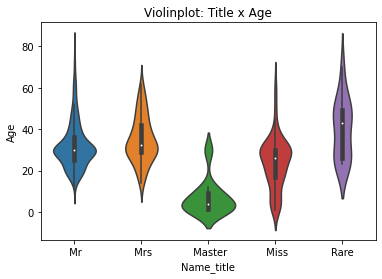

In [1245]:
import seaborn as sns
import matplotlib.pyplot as plt

pipe_violin_title_age = make_pipeline(    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          Mapper(features=['Sex'],map_dict=sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),)
x_train_2 = pipe_violin_title_age.fit_transform(x_train)

sns.violinplot(x_train_2['Name_title'],x_train_2['Age'])
plt.title('Violinplot: Title x Age')
plt.show()

More so, it even carries some info about age and as seen in the EDA in pt 1 of this notebook, it also carries info about Fare/Pclass.

# 4.6 Cabin

In [1287]:
class Cabin_code(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self):
        pass
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame,y:pd.Series=None):
        x = x.copy()
        try:
            x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
            x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
        except Exception as err:
            print('erro no Cabin_code')
            print(err)
        return x

In [1303]:
pipe_cabin = make_pipeline(
    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          CategoricalImputer(variables='Cabin',fill_value='Missing'),
                          Cabin_code(),                          
                          OneHotEncoder(top_categories=4, variables=['Name_family','Name_title','Cabin_code']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_cabin,5)

accuracy of 0.7994 and standard deviation of 0.037


In [1311]:
pipe_cabin = make_pipeline(
                        #categorical features transformations
                          get_name(family=True,title=True),
                          CategoricalImputer(variables='Cabin',fill_value='?'),
                          Cabin_code(),
                          #RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          #RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          #fix_rare_labels(variables=['Cabin_code'], threshold=[25]),
                          OneHotEncoder(top_categories=4, variables=['Name_family','Name_title','Cabin_code']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                          RandomForestClassifier(random_state=0))
get_cross_score(pipe_cabin,5)

accuracy of 0.7994 and standard deviation of 0.037


In [1299]:
pipe_cabin = make_pipeline(
                        #categorical features transformations
                          get_name(family=True,title=True),
                          CategoricalImputer(variables='Cabin',fill_value='?'),
                          Cabin_code(),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Cabin_code']),)
x_cabin = pipe_cabin.fit_transform(x_train)
x_cabin['Cabin_code'].value_counts()

?    471
C     42
B     31
E     27
D     26
A     14
F      9
G      2
T      1
Name: Cabin_code, dtype: int64

# 4.7 Embarked 

# ======== why does my custom rare label encoder lowers the acc?

It seem to be doing the same thing. switching rarelabelencoder to tol=0.005 also decreases the acc but it shouldn't do anything diferent.

In [1178]:
pipe_test = make_pipeline(    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10]),
                          OneHotEncoder(variables=['Name_family','Name_title']),
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_test,5)

accuracy of 0.7946 and standard deviation of 0.0466


In [1211]:
pipe_test = make_pipeline(    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          RareLabelEncoder(tol=0.005,variables=['Name_family']),
                          RareLabelEncoder(tol=0.005,variables=['Name_title']),)
x_sex = pipe_test.fit_transform(x_train)
x_sex["Name_family"].value_counts()

Rare         585
Andersson      7
Sage           7
Goodwin        4
Lefebre        4
Brown          4
Rice           4
Ford           4
Carter         4
Name: Name_family, dtype: int64

In [1191]:
4/len(x_train)

0.006420545746388443

In [1172]:
pipe_test = make_pipeline(    
                        #categorical features transformations
                          get_name(family=True,title=True),
                          fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10]))
x_sex = pipe_test.fit_transform(x_train)
x_sex["Name_family"].value_counts()

Rare         585
Andersson      7
Sage           7
Goodwin        4
Lefebre        4
Brown          4
Rice           4
Ford           4
Carter         4
Name: Name_family, dtype: int64

# Under development
# =========below this line, everything is "thrash" code ============

## Scikit-learn approach

Using pipeline and column transformers

In [109]:
cat_pipe = make_pipeline( SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=False),
                                    OneHotSK(handle_unknown='ignore'))

num_pipe = make_pipeline( SimpleImputer(missing_values=np.nan, strategy='median',add_indicator=False))

pipe_merge = ColumnTransformer( [("numeric_transf", num_pipe, make_column_selector(dtype_exclude=object)),
                                        ("categorical_transf", cat_pipe, make_column_selector(dtype_include=object))])


In [110]:
sk_pipe = Pipeline(steps=[
                    ('Fix dtype',dtype_fix),
                    ('Get name infos',get_name),
                    ('Get cabin infos', Cabin_code()),
                    return_title
                    ('Encode SEX', Mapper(features=['Sex'],map_dict = sex_map)),
                    ('Merge Cat and Num',pipe_merge),
                    ('RF model',RandomForestClassifier(random_state=0))])

In [111]:
get_cross_score(sk_pipe)

accuracy of 0.8121 and standard deviation of 0.0415


In [104]:
from sklearn import set_config  
set_config(display='diagram')  

In [105]:
sk_pipe

Pipeline(steps=[('Fix dtype',
                 FunctionTransformer(func=<function corrige_type at 0x0000025CFFD061F0>)),
                ('Get name infos',
                 FunctionTransformer(func=<function name_information at 0x0000025CFFCB31F0>)),
                ('Get cabin infos', Cabin_code()),
                ('Encode SEX',
                 Mapper(features=['Sex'],
                        map_dict={'?': -999, 'female': 0, 'male': 1})),
                ('Merge Cat and Num',
                 ColumnTransformer(transformers=[('...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025CFFD8BD90>),
                                                 ('categorical_transf',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025CFFD8B1F0>)])),
                ('RF model', RandomForestClassifier(random_state=0))])

## Feature-engine approach

In [106]:
#basic pre processing 
pipe_pp = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        Fill_na_transf(fill_na="?"),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        OneHotEncoder(top_categories = 3, variables=['Cabin_code','Title','Embarked']),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']),)

In [107]:
pipe_pp

Pipeline(steps=[('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age'])),
                ('fill_na_transf', Fill_na_transf(fill_na='?')),
                ('cabin_code', Cabin_code()), ('get_title', Get_title()),
                ('mapper',
                 Mapper(features=['Sex'],
                        map_dict={'?': -999, 'female': 0, 'male': 1})),
                ('onehotencoder',
                 OneHotEncoder(top_categories=3,
                               variables=['Cabin_code', 'Title', 'Embarked'])),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin']))])

In [33]:
x_base = pipe_base.fit_transform(x_train)
x_base.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Size,Cabin_code_?,Cabin_code_C,Cabin_code_B,Title_Mr,Title_Miss,Title_Mrs,Embarked_S,Embarked_C,Embarked_Q
PassengerId,,,,,,,,,,,,,,,,
446,1,1,4.000000,0,2,81.8583,1,0,0,0,0,0,0,1,0,0
651,3,1,29.256353,0,0,7.8958,1,1,0,0,1,0,0,1,0,0
173,3,0,1.000000,1,1,11.1333,1,1,0,0,0,1,0,1,0,0
451,2,1,36.000000,1,2,27.7500,1,1,0,0,1,0,0,1,0,0
315,2,1,43.000000,1,1,26.2500,1,1,0,0,1,0,0,1,0,0


In [38]:
pipe_rf = make_pipeline(pipe_base,RandomForestClassifier(random_state=0))
score_base = cross_val_score(pipe_rf, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_base.mean(),4)} and standard deviation of {np.round(score_base.std(),4)}')

accuracy of 0.8203 and standard deviation of 0.0348


In [330]:
# filling na of "Age" with median instead of mean
pipe_base2 = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        Fill_na_transf(fill_na="?"),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        OneHotEncoder(top_categories = 3, variables=['Cabin_code','Title','Embarked']),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']),
                        Winsorizer(variables=["Age","Fare"],capping_method='quantiles', fold=0.05),
                        RandomForestClassifier(random_state=42))

In [331]:
score_base2 = cross_val_score(pipe_base2, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_base2.mean(),4)} and standard deviation of {np.round(score_base2.std(),4)}')

accuracy of 0.8236 and standard deviation of 0.0357


In [473]:
#basic pre processing 
pipe_2 = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        Fill_na_transf(fill_na='?'),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        OneHotEncoder(top_categories = 3, variables=['Cabin_code','Title','Embarked']),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']))

In [474]:
x_eda_ = pipe_2.fit_transform(x_train)